<a href="https://colab.research.google.com/github/KwonYN/TIL/blob/master/PYTHON/TENSORFLOW/Ch3_%EC%98%88%EC%A0%9C_19_MNIST_MLP_BN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter3-5. Deep Learning 기초 : Multi Layer Perceptron (MLP)

>## [예제3-19] MNIST Classification : MLP-Batch_Normalization

>### Load modules

In [25]:
%tensorflow_version 1.x

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

print("Module Loaded.")
print("NumPy Version :{}".format(np.__version__))
print("TensorFlow Version :{}".format(tf.__version__))
print("Matplotlib Version :{}".format(plt.matplotlib.__version__))

Module Loaded.
NumPy Version :1.17.4
TensorFlow Version :1.15.0
Matplotlib Version :3.1.1


> ### Load MNIST Data

In [0]:
(train_data, train_labels), (test_data, test_labels) = mnist.load_data()

train_data = train_data.astype(np.float32)
train_data = train_data / 255.0

test_data = test_data.astype(np.float32)
test_data = test_data / 255.0

# 이 코드가 사라졌을 것임. tensorflow.layers.flatten으로 한 번에 가능.
#train_data = train_data.reshape((-1, 784))    # 28 * 28이었던 녀석을 Flattening한 것! :★( 행은 알아서 결정해주고!(batch size겠지!?), 열은 784로 해줘! )
#test_data = test_data.reshape((-1, 784))

train_labels = train_labels.reshape((-1, 1))
test_labels = test_labels.reshape((-1, 1))

> ### Placeholder

In [0]:
x_ph = tf.placeholder(tf.float32, shape=(None, 28, 28), name = "input")
labels_ph = tf.placeholder(tf.int32, shape=(None,1), name="labels")

>### Hypothesis, Cost, Optimizer


In [0]:
categories = 10
learning_rate = 0.001

# activation=~~ : 파라미터로 이렇게 선언을 해줌으로써 w와 b가 생기게 되고,
#                 이 변수들에 대한 초기값이 필요하기 때문에 'kernel_initializer=~~~, bias_initializer=~~'와 같이 추가해줘야 함!

# input layer -> hidden layer
x_flatten = tf.layers.flatten(x_ph) # 최상위 dimension은 제외하고(batch size에 대해서는 바뀌지 않음) 그 하위 dimension을 1차원으로 flattening 시키는 것! 
layer1 = tf.layers.dense(x_flatten, 256, activation=tf.nn.sigmoid, kernel_initializer=tf.glorot_uniform_initializer, bias_initializer=tf.glorot_uniform_initializer)
layer1_bn = tf.layers.batch_normalization(layer1)
# => layer1의 shape = (batch size, 256)

# hidden layer -> output layer
layer2 = tf.layers.dense(layer1_bn, 256, activation=tf.nn.sigmoid, kernel_initializer=tf.glorot_uniform_initializer, bias_initializer=tf.glorot_uniform_initializer)
layer2_bn = tf.layers.batch_normalization(layer2)
# => layer2의 shape = (batch size, 256)

# for softmax
layer3_logits = tf.layers.dense(layer2_bn, categories, kernel_initializer=tf.glorot_normal_initializer, bias_initializer=tf.glorot_normal_initializer)
hypothesis = tf.nn.softmax(layer3_logits) # 즉, 10개의 클래스/카테고리에 대해서 그 카테고리인지 아닌지에 대한 Decision Boundary를 그려줄 것! (10번)
# => hypothesis의 shape = (batch size, 카테고리 수=10)

labels_oh = tf.one_hot(labels_ph, categories)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels_oh, layer3_logits))
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train = optimizer.minimize(cost)


>### Mini-Batch 관련

In [0]:
N_epoch = 1000
batch_size = 128
train_data_size = train_data.shape
batch_count = train_data_size[0] //batch_size

>### Accuracy

In [0]:
def Accuracy(y:np.ndarray, t:np.ndarray)->np.float32:
    return np.mean(np.equal(np.argmax(y, axis=1).reshape((-1, 1)),t).astype(np.float32))

>### 결과 출력을 위한 함수

In [0]:
def Make_Result_Plot(suptitle:str, data:np.ndarray, label:np.ndarray, y_max:np.ndarray):
    fig_result, ax_result = plt.subplots(2,5,figsize=(18, 7))
    fig_result.suptitle(suptitle)
    for idx in range(10):
        ax_result[idx//5][idx%5].imshow(data[idx].reshape((28,28)),cmap="binary")
        ax_result[idx//5][idx%5].set_title("test_data[{}] (label : {} / y : {})".format(idx, label[idx], y_max[idx]))

> ### Training 준비

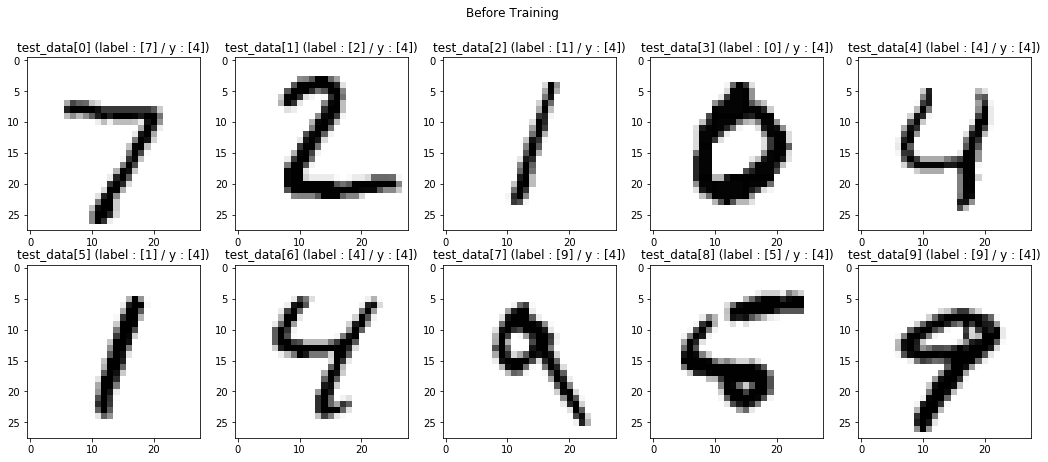

In [32]:
arr_epoch = []
arr_accu = []

# 학습 (Training)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

train_data_idx = np.arange(train_data_size[0])

y_out = sess.run(hypothesis, feed_dict={x_ph: test_data})
y_max = np.argmax(y_out, axis=1).reshape((-1, 1))
Make_Result_Plot("Before Training", test_data, test_labels, y_max)

accu = Accuracy(y_out,test_labels)
arr_epoch.append(0)
arr_accu.append(accu)

> ### 학습 (Training)

In [33]:
%%time
for epoch_idx in range(1, N_epoch+1):
    np.random.shuffle(train_data_idx)
    for batch_idx in range(batch_count):

        batch_data = np.array([train_data[train_data_idx[batch_idx * batch_size + idx]] for idx in range(batch_size)])
        batch_labels = np.array([train_labels[train_data_idx[batch_idx * batch_size + idx]] for idx in range(batch_size)])
        
        sess.run(train, feed_dict={x_ph: batch_data, labels_ph: batch_labels})
    if epoch_idx%1 == 0:
        y_out = sess.run(hypothesis, feed_dict={x_ph: test_data})
        accu = Accuracy(y_out,test_labels)
        print("[{:>5}] accuracy = {:>10.4}".format(epoch_idx,accu))
        arr_epoch.append(epoch_idx)
        arr_accu.append(accu)

[    1] accuracy =      0.928
[    2] accuracy =     0.9462
[    3] accuracy =      0.956
[    4] accuracy =     0.9653
[    5] accuracy =     0.9713
[    6] accuracy =     0.9705
[    7] accuracy =     0.9755
[    8] accuracy =     0.9776
[    9] accuracy =     0.9795
[   10] accuracy =     0.9787
[   11] accuracy =     0.9767
[   12] accuracy =     0.9807
[   13] accuracy =     0.9806
[   14] accuracy =     0.9801
[   15] accuracy =      0.981
[   16] accuracy =     0.9804
[   17] accuracy =     0.9807
[   18] accuracy =     0.9811
[   19] accuracy =     0.9796


KeyboardInterrupt: ignored

> ### Ploting : Cost/Training Count

In [0]:
# Plot : Accuracy / Epoch
fig_accu, ax_accu = plt.subplots()
ax_accu.plot(arr_epoch, arr_accu)
ax_accu.set_title("Accuracy / Epoch (MLP, Gradient Descent Optimizer)")
ax_accu.grid(True)
ax_accu.set_ylim(0,1.1)

> ### Training 이후

In [0]:
y_out = sess.run(hypothesis, feed_dict={x_ph: test_data})
y_max = np.argmax(y_out, axis=1).reshape((-1, 1))
Make_Result_Plot("After Training", test_data, test_labels, y_max)